In [1]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {DEVICE}")

using PyTorch version: 2.2.2+cu118, Device: cuda


In [3]:
# 데이터 다운로드

import requests

url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
response = requests.get(url)
with open("cats_and_dogs_filtered.zip", "wb") as f:
    f.write(response.content)


In [4]:
import os

ROOT_DIR = './'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'cats_and_dogs_filtered')

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')

VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'validation')

In [5]:
import os
import shutil

if os.path.exists('./cats_and_dogs_filtered/'):    # 작업 디렉토리는 cats_and_dogs_filtered

    shutil.rmtree('./cats_and_dogs_filtered/')
    print('./cats_and_dogs_filtered/  is removed !!!')

./cats_and_dogs_filtered/  is removed !!!


In [6]:

# 압축파일 풀기

import zipfile

with zipfile.ZipFile('./cats_and_dogs_filtered.zip', 'r') as target_file:

    target_file.extractall('./')

In [7]:
import os

# train data 개수

train_cats_list = os.listdir('./cats_and_dogs_filtered/train/cats/')

train_dogs_list = os.listdir('./cats_and_dogs_filtered/train/dogs/')

# validation data 개수

test_cats_list = os.listdir('./cats_and_dogs_filtered/validation/cats/')

test_dogs_list = os.listdir('./cats_and_dogs_filtered/validation/dogs/')

print(len(train_cats_list), len(train_dogs_list))

print(len(test_cats_list), len(test_dogs_list))

1000 1000
500 500


In [8]:
train_config = transforms.Compose([transforms.Resize((224,224)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor()])

validation_config = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.ToTensor()])

In [9]:
train_dataset = datasets.ImageFolder('./cats_and_dogs_filtered/train/', train_config)

validation_dataset = datasets.ImageFolder('./cats_and_dogs_filtered/validation/', validation_config)

test_dataset = datasets.ImageFolder('./cats_and_dogs_filtered/validation/', validation_config)

In [10]:
BATCH_SIZE = 32

train_dataset_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# 1개의 배치를 추출

images, labels = next(iter(train_dataset_loader))

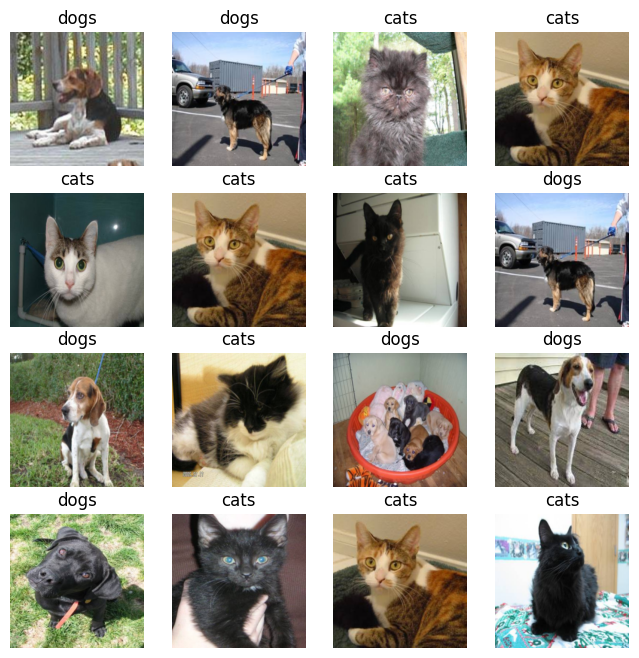

In [12]:
import matplotlib.pyplot as plt

# ImageFolder의 속성 값인 class_to_idx를 할당

labels_map = { v:k  for k, v in train_dataset.class_to_idx.items() }

figure = plt.figure(figsize=(8, 8))

cols, rows = 4, 4

# 이미지 출력

for i in range(1, cols*rows+1):

    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()

    figure.add_subplot(rows, cols, i)

    plt.title(labels_map[label])
    plt.axis("off")

    # 본래 이미지의 shape은 (3, 224, 224) 인데,
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (224, 224, 3)으로 shape 변경을 한 후 시각화
    plt.imshow(torch.permute(img, (1, 2, 0)))

plt.show()

In [13]:
from torchvision import transforms, models

pretrained_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

print(pretrained_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [14]:
class MyTransferLearningModel(torch.nn.Module):

    def __init__(self, pretrained_model, feature_extractor):

        super().__init__()

        if (feature_extractor):
            for param in pretrained_model.parameters():
                param.require_grad = False

        # vision transformer 에서의 classifier 부분은 heads 로 지정
        pretrained_model.heads = torch.nn.Sequential(
            torch.nn.Linear(pretrained_model.heads[0].in_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 2)
        )

        self.model = pretrained_model

    def forward(self, data):

        logits = self.model(data)

        return logits

In [15]:
feature_extractor = False  # True: Feature Extractor,  False: Fine Tuning

model = MyTransferLearningModel(pretrained_model, feature_extractor).to(DEVICE)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-6)

In [16]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader:

        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

        train_total += y_train.size(0)
        train_correct += ((torch.argmax(outputs, 1)==y_train)).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch
    train_avg_accuracy = 100*train_correct / train_total

    return (train_avg_loss, train_avg_accuracy)

In [17]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval()

    with torch.no_grad():

        val_loss_sum = val_correct = val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader:

            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [18]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = test_correct = test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [19]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 30

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
          'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


epoch: 01 train loss = 0.636 train acc = 73.000 val loss = 0.587 val acc = 94.700
epoch: 02 train loss = 0.541 train acc = 89.250 val loss = 0.479 val acc = 98.300
epoch: 03 train loss = 0.430 train acc = 95.050 val loss = 0.360 val acc = 98.800
epoch: 04 train loss = 0.317 train acc = 98.000 val loss = 0.257 val acc = 99.000
epoch: 05 train loss = 0.231 train acc = 98.900 val loss = 0.179 val acc = 99.200
epoch: 06 train loss = 0.162 train acc = 99.100 val loss = 0.130 val acc = 99.200
epoch: 07 train loss = 0.121 train acc = 99.450 val loss = 0.098 val acc = 99.000
epoch: 08 train loss = 0.092 train acc = 99.650 val loss = 0.076 val acc = 99.100
epoch: 09 train loss = 0.067 train acc = 99.850 val loss = 0.062 val acc = 99.100
epoch: 10 train loss = 0.054 train acc = 99.800 val loss = 0.054 val acc = 98.900
epoch: 11 train loss = 0.043 train acc = 99.950 val loss = 0.046 val acc = 99.000
epoch: 12 train loss = 0.036 train acc = 99.950 val loss = 0.042 val acc = 99.100
epoch: 13 train 

In [20]:
# test dataset 으로 정확도 및 오차 테스트

model_test(test_dataset_loader, model)

accuracy: 98.9
loss: 0.034995604888536036


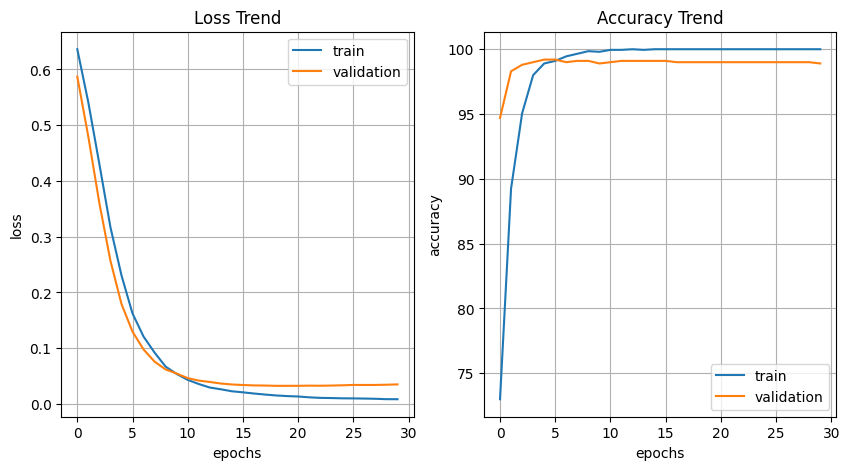

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix
# from matplotlib import pyplot as plt
# import seaborn as sns
# import numpy as np

# sns.set_style("whitegrid")
# plt.figure(figsize=(6,6))
# cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(outputs, axis=-1))
# sns.heatmap(cm, annot=True, fmt="d")
# plt.title("Confusion Matrix")
# plt.ylabel("True label")
# plt.xlabel('Predict label')
# plt.show()